# imports

In [8]:
# pip install pykalman

import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
import time
import torch

import torch.nn as nn
import torch.nn.functional as F
import math
from torch.autograd import Variable

import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
from numpy.linalg import norm

random_state = np.random.RandomState(0)
torch.manual_seed(0)
T = 0.01
step = 200

In [19]:
state_machine_input_dim = 19
state_machine_feature_vector_dim = 512
output_head_dim = 10
label_dim = 10

# lstm

In [16]:
def create_dataset(datas, look_back):
    dataset = datas.astype('float32')
    max_value = np.max(dataset)
    min_value = np.min(dataset)
    scalar = max_value - min_value
    dataset = list(map(lambda x: x / scalar, dataset))
    #look_back = 3
    #window_wid = 2*look_back

    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return dataset, np.array(dataX), np.array(dataY)

class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=3):
        super(lstm_reg, self).__init__()
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers)#,dropout=1)
          #bidirectional=True) # rnn
        self.reg = nn.Linear(hidden_size, output_size) # regression
        
    def forward(self, x):
        x, _ = self.rnn(x) # (seq, batch, hidden)
        s, b, h = x.shape
        x = x.view(s*b, h)
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x

def lstm_train(datas,look_back=5,step = 200,epochtime = 100):
    dataset, data_X, data_Y = create_dataset(datas,look_back)
    train_size = int(len(data_X)*0.9)
    test_size = len(data_X) - train_size
    train_X = data_X[:train_size]
    train_Y = data_Y[:train_size]
    test_X = data_X[train_size:]
    test_Y = data_Y[train_size:]
    train_X = train_X.reshape(-1, 1, look_back)
    train_Y = train_Y.reshape(-1, 1, 1)
    test_X = test_X.reshape(-1, 1, look_back)

    train_x = torch.from_numpy(train_X)
    train_y = torch.from_numpy(train_Y)
    test_x = torch.from_numpy(test_X)
    
    net = lstm_reg(look_back, 2*look_back)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(),lr=0.01)
    loss_list = []
    for e in range(epochtime):
        var_x = Variable(train_x)
        var_y = Variable(train_y)
        out = net(var_x)
        loss = criterion(out, var_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        if (e + 1) % 10 == 0:
            print("lstm")
            print(out.shape)
            print(var_x.shape)
            print(train_y.shape)
            print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))
    
    net = net.eval() 
    data_X = data_X.reshape(-1, 1, look_back)
    data_X = torch.from_numpy(data_X)
    var_data = Variable(data_X)
    pred_test = net(var_data)
    pred_test = pred_test.view(-1).data.numpy()
    pred_test = np.concatenate((np.array(dataset)[:look_back],pred_test))
    
    return pred_test,loss_list

# transformer

In [17]:


class TransformerBlock(nn.Module):
    """
    Bidirectional Encoder = Transformer (self-attention)
    Transformer = MultiHead_Attention + Feed_Forward with sublayer connection
    """

    def __init__(self, hidden, attn_heads, feed_forward_hidden, dropout):
        """
        :param hidden: hidden size of transformer
        :param attn_heads: head sizes of multi-head attention
        :param feed_forward_hidden: feed_forward_hidden, usually 4*hidden_size
        :param dropout: dropout rate
        """

        super().__init__()
        self.attention = MultiHeadedAttention(h=attn_heads, d_model=hidden)
        self.feed_forward = PositionwiseFeedForward(d_model=hidden, d_ff=feed_forward_hidden, dropout=dropout)
        self.input_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.output_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.dropout = nn.Dropout(p=dropout)
        self.hidden = hidden




    def forward(self, x, mask):
        self.position = PositionalEmbedding(self.hidden, x.size()[1])

        x = x + self.position(x)
        x = self.input_sublayer(x, lambda _x: self.attention.forward(_x, _x, _x, mask=mask))
        x = self.output_sublayer(x, self.feed_forward)
        return self.dropout(x)


class PositionalEmbedding(nn.Module):

    def __init__(self, d_model, max_len=512):
        super().__init__()

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]


class MultiHeadedAttention(nn.Module):
    """
    Take in model size and number of heads.
    """

    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        assert d_model % h == 0

        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h

        self.linear_layers = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(3)])
        self.output_linear = nn.Linear(d_model, d_model)
        self.attention = Attention()

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [l(x).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linear_layers, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch.
        x, attn = self.attention(query, key, value, mask=mask, dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.h * self.d_k)

        return self.output_linear(x)



class Attention(nn.Module):
    """
    Compute 'Scaled Dot Product Attention
    """

    def forward(self, query, key, value, mask=None, dropout=None):
        scores = torch.matmul(query, key.transpose(-2, -1)) \
                 / math.sqrt(query.size(-1))

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        p_attn = F.softmax(scores, dim=-1)

        if dropout is not None:
            p_attn = dropout(p_attn)

        return torch.matmul(p_attn, value), p_attn

class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()

    def forward(self, x):
        return self.w_2(self.dropout(self.activation(self.w_1(x))))

class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."

    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

class GELU(nn.Module):
    """
    Paper Section 3.4, last paragraph notice that BERT used the GELU instead of RELU
    """

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

def transformer_train(datas,hidden,sample_size=1,max_len=1,attn_heads = 4,dropout = 0.1,epochtime = 500):
    
    net = TransformerBlock(hidden, attn_heads, hidden * 4, dropout)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(),lr=0.01)
    loss_list = []
    datas = datas.reshape(sample_size, max_len, hidden)
    datas = torch.Tensor(datas)
    for e in range(epochtime):
        out = net(datas,mask=None)
        
        
        
        loss = criterion(out, datas)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        if (e + 1) % 50 == 0:
            print("transformer")
            print(out.shape)
            print(datas.shape)
            print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))
    
    net = net.eval()
    var_data = Variable(datas)
    pred_test = net(var_data,mask=None)
    pred_test = pred_test.view(-1).data.numpy().reshape(hidden)
    return pred_test,loss_list


In [20]:
np.eye(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

# main

----transformer+lstm----
transformer
torch.Size([1, 1, 200])
torch.Size([1, 1, 200])
Epoch: 50, Loss: 2.72823
transformer
torch.Size([1, 1, 200])
torch.Size([1, 1, 200])
Epoch: 100, Loss: 0.63334
transformer
torch.Size([1, 1, 200])
torch.Size([1, 1, 200])
Epoch: 150, Loss: 0.36294
transformer
torch.Size([1, 1, 200])
torch.Size([1, 1, 200])
Epoch: 200, Loss: 0.81870
transformer
torch.Size([1, 1, 200])
torch.Size([1, 1, 200])
Epoch: 250, Loss: 0.78820
transformer
torch.Size([1, 1, 200])
torch.Size([1, 1, 200])
Epoch: 300, Loss: 0.43333
transformer
torch.Size([1, 1, 200])
torch.Size([1, 1, 200])
Epoch: 350, Loss: 0.60223
transformer
torch.Size([1, 1, 200])
torch.Size([1, 1, 200])
Epoch: 400, Loss: 0.49222
transformer
torch.Size([1, 1, 200])
torch.Size([1, 1, 200])
Epoch: 450, Loss: 0.38936
transformer
torch.Size([1, 1, 200])
torch.Size([1, 1, 200])
Epoch: 500, Loss: 0.65248
lstm
torch.Size([175, 1, 1])
torch.Size([175, 1, 5])
torch.Size([175, 1, 1])
Epoch: 10, Loss: 0.04319
lstm
torch.Siz

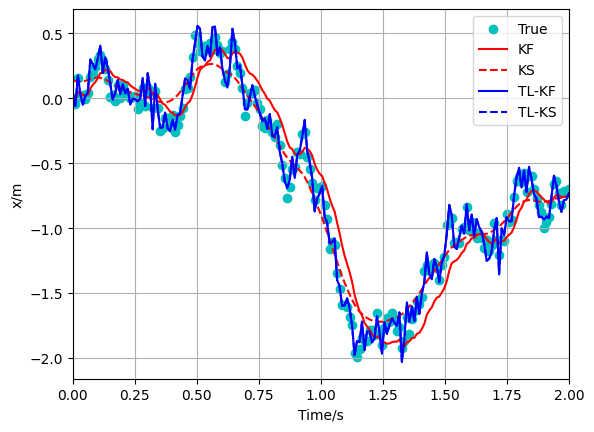

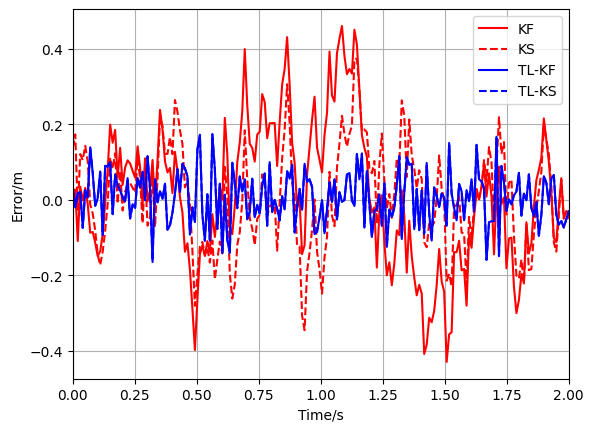

In [18]:


'''
Step 1: Provide a de facto system
'''

A= np.array([[1,T, 0.5*T*T],
 [ 0, 1,T],
 [ 0, 0, 1]])
B= [0, 0, 0]
C= [1,0,0]
D= [0]
Q= 0.01*np.eye(3)
R= 0.005*np.eye(1)
m0= [ 0,0,0.1]
P0= 0.1*np.eye(3)

kft = KalmanFilter(
    A,C,Q,R,B,D,m0,P0,
    random_state=random_state
)# model should be
state, observation = kft.sample(
    n_timesteps=step,
    initial_state=m0
)# provide data
#filtered_state_estimatet, f_covt = kft.filter(observation)
#smoothed_state_estimatet, s_covt = kft.smooth(observation)

'''
Step 2: Initialize our model
'''

# specify parameters
transition_matrix = A
transition_offset = B
observation_matrix = C
observation_offset = D
transition_covariance = 0.02*np.eye(3)
observation_covariance = np.eye(1)
initial_state_mean =[0,0,1]
initial_state_covariance = 5*np.eye(3)

# sample from model
kf = KalmanFilter(
    transition_matrix, observation_matrix, transition_covariance,
    observation_covariance, transition_offset, observation_offset,initial_state_mean,initial_state_covariance,
    random_state=random_state,
    em_vars=[
      #'transition_matrices', 'observation_matrices',
      'transition_covariance','observation_covariance',
      #'transition_offsets', 'observation_offsets',
      'initial_state_mean', 'initial_state_covariance'
      ]
)

data = kf.sample(n_timesteps=step,initial_state=initial_state_mean)[1]
filtered_state_estimater, nf_cov = kf.filter(observation)
smoothed_state_estimater, ns_cov = kf.smooth(observation)

'''
Step 3: Learn good values for parameters named in `em_vars` using the EM algorithm
'''

def compute_tr(a):
    size = a.shape[0]
    return (np.trace(a)/size)*np.eye(size)

def test(data,method='TL',n_iteration=10):
    t_start = time.process_time()
    if method == 'TL':
        print('----transformer+lstm----')
        data,loss_list = transformer_train(data,step)
        data,loss_list = lstm_train(data)
        labelfilter = 'TL-KF'
        labelsmooth = 'TL-KS'
    elif method == 'L':
        print('----lstm----')
        data,loss_list = lstm_train(data)
        labelfilter = 'LSTM-KF'
        labelsmooth = 'LSTM-KS'
    elif method == 'T':
        print('----transformer----')
        data,loss_list = transformer_train(data,step)
        labelfilter = 'Transformer-KF'
        labelsmooth = 'Transformer-KS'
    else:
        print('----EM----')
        labelfilter = 'EM-KF'
        labelsmooth = 'EM-KS'
    
    t_train = time.process_time()
    kfem = kf.em(X=data, n_iter=n_iteration)
    t_em = time.process_time()
    print('train-time/sec',t_train-t_start)
    print('em-time/sec',t_em-t_train)
    Qem = compute_tr(kfem.transition_covariance)
    Rem = compute_tr(kfem.observation_covariance)
    P0em = compute_tr(kfem.initial_state_covariance)
    m0em = [0,0,np.abs(kfem.initial_state_mean[2])]
    print('Q=',Qem)
    print('R=',Rem)
    print('m0=',m0em)
    print('P0=',P0em)
    kfem = KalmanFilter(
        A,C,Qem,Rem,B,D,m0em,P0em,
        random_state=random_state
    )
    #obsem = kfem.sample(n_timesteps=step,initial_state=m0)[1]
    filtered_state_estimates, f_cov = kfem.filter(observation)
    smoothed_state_estimates, s_cov = kfem.smooth(observation)
    return filtered_state_estimates, f_cov, smoothed_state_estimates, s_cov,labelfilter,labelsmooth


# draw estimates
filtered_state_estimates, f_cov, smoothed_state_estimates, s_cov, labelfilter,labelsmooth = test(data[:,0],n_iteration=10)
#print('emkf=',filtered_state_estimates[:,0].tolist())
#print('emks=',smoothed_state_estimates[:,0].tolist())
filtered_delta_estimater = filtered_state_estimater[:,0] - state[:,0]
smoothed_delta_estimater = smoothed_state_estimater[:,0] - state[:,0]
filtered_delta_estimates = filtered_state_estimates[:,0] - state[:,0]
smoothed_delta_estimates = smoothed_state_estimates[:,0] - state[:,0]
'''
filtered_delta_estimates_lstm = filtered_state_estimates_lstm[:,0] - state[:,0]
smoothed_delta_estimates_lstm = smoothed_state_estimates_lstm[:,0] - state[:,0]
filtered_delta_estimates_tranf = filtered_state_estimates_tranf[:,0] - state[:,0]
smoothed_delta_estimates_tranf = smoothed_state_estimates_tranf[:,0] - state[:,0]
'''
#smoothed_delta_estimates[step-1] = smoothed_delta_estimates[step-3]
# lines_true = plt.plot(state[:,0],state[:,1] ,color='c',label='true')
#lines_model = plt.plot(state, color='m')
msefr = np.linalg.norm(filtered_delta_estimater)**2/step
msesr = np.linalg.norm(smoothed_delta_estimater)**2/step
msefs = np.linalg.norm(filtered_delta_estimates)**2/step
msess = np.linalg.norm(smoothed_delta_estimates)**2/step
print('----MSE----')
print('KF',msefr)
print('KS',msesr)
print(labelfilter,msefs)
print(labelsmooth,msess)

#draw
taxis = np.linspace(0,step*T,step)
plt.figure()
lines_filter = plt.scatter(taxis,state[:,0], color='c',label='True')
lines_filter = plt.plot(taxis,filtered_state_estimater[:,0], 'r',label='KF')
lines_smoother = plt.plot(taxis,smoothed_state_estimater[:,0], 'r--',label='KS')
lines_filt = plt.plot(taxis,filtered_state_estimates[:,0], 'b',label=labelfilter)
lines_smooth = plt.plot(taxis,smoothed_state_estimates[:,0], 'b--',label=labelsmooth)
plt.xlim(0,step*T)
plt.xlabel('Time/s')
plt.ylabel('x/m')
plt.legend()
plt.grid()
plt.figure()
dlines_filter = plt.plot(taxis,filtered_delta_estimater, 'r',label='KF')
dlines_smoother = plt.plot(taxis,smoothed_delta_estimater, 'r--',label='KS')
dlines_filt = plt.plot(taxis,filtered_delta_estimates, 'b',label=labelfilter)
dlines_smooth = plt.plot(taxis,smoothed_delta_estimates, 'b--',label=labelsmooth)
#plt.plot(observation[:,0] - state[:,0],color='c')
plt.xlim(0,step*T)
plt.xlabel('Time/s')
plt.ylabel('Error/m')
plt.legend()
plt.grid()
plt.show()
#lines_filt1 = plt.plot(filtered_state_estimates1, color='b')
#lines_smooth1 = plt.plotsmoothed_delta_estimates1, color='k')
